# UTR Data Analysis

### Aleksander Kossakowski, 23.05.2025

**Research question**  
How do sequence length and untranslated region (UTR) type (3′ vs 5′) influence GC content, and what patterns in motif composition underlie any differences?

This notebook follows the structure of:

* Exploratory Data Analysis (EDA) 
* Principal Component Analysis (PCA) of motif counts  
* Welch’s *t*-test comparing GC% between UTR types, with 95 % CI  
* Linear regression of GC% on length and UTR type  
* Assumption checks for each method  
* Short discussion of every result


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")


In [2]:
df = pd.read_csv('utr_motif_data.tsv', sep='\t')
#df.head()

## EDA - descriptive

In [3]:
df[['Length','GCpercent']].describe().loc[['mean','25%','50%','75%','max']]

,Length,GCpercent
mean,238.502,0.552906
25%,56.000,0.439024
50%,114.000,0.555556
75%,228.000,0.664643
max,9908.000,1.000000


### What `df.describe()` tells us about the data

*Sample size*  
* **4 000** UTR sequences are included in the dataset for every variable listed.

---

#### Length (nucleotides)
| Statistic | Value | Interpretation |
|-----------|-------|----------------|
| Mean | **238 nt** | Average UTR is short. |
| Median (50 %) | **114 nt** | Much smaller than the mean ⇒ **strong right-skew**. |
| 75 % | 228 nt | Three-quarters of UTRs are ≤ 228 nt. |
| Max | **9 908 nt** | A few extreme outliers inflate the mean (SD ≈ 483 nt). |

*Implication*: **Length** is highly skewed.

---

#### GC content
| Statistic | Value | Interpretation |
|-----------|-------|----------------|
| Mean | **0.553** | Average GC ≈ 55 %. |
| Median | 0.556 | Close to mean ⇒ fairly symmetric. |
| IQR (25–75 %) | 0.439 – 0.665 | Most sequences sit between 44 % and 66 % GC. |
| Range | 0 – 1 | Full range present, but extremes are rare. |

*Implication*: Variance is moderate.

---

### Key take-aways
1. **Length** needs skew-robust treatment (e.g., log-scale).  
2. **GC %** is roughly symmetric and bounded.  
3. **Motif variables** behave like count data with excess zeros.
4. **Outliers** are very long UTRs or high motif counts.



In [4]:
# summary stats for each UTR type
by_type_summary = (
    df.groupby('Type')
      .describe()
      .transpose()
)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(by_type_summary)


Type                   3pUTR        5pUTR
Length    count  2000.000000  2000.000000
          mean    322.319500   154.684500
          std     652.740328   165.753770
          min       1.000000     1.000000
          25%      56.000000    55.000000
          50%     123.500000   107.000000
          75%     299.000000   192.000000
          max    9908.000000  1802.000000
GCpercent count  2000.000000  2000.000000
          mean      0.479079     0.626733
          std       0.126588     0.131230
          min       0.000000     0.000000
          25%       0.389682     0.542043
          50%       0.479088     0.644608
          75%       0.565755     0.725806
          max       1.000000     1.000000
ACAUACU   count  2000.000000  2000.000000
          mean      0.023500     0.002500
          std       0.173097     0.049950
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       0.000000     0.000000
          max       3.000000     1.000000
ACAUAC    count  2000.000000  2000.000000
          mean      0.058500     0.014000
          std       0.274072     0.117520
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       0.000000     0.000000
          max       3.000000     1.000000
ACAUA     count  2000.000000  2000.000000
          mean      0.294500     0.044500
          std       0.891722     0.244028
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       0.000000     0.000000
          max      15.000000     4.000000
ACAU      count  2000.000000  2000.000000
          mean      1.424500     0.271000
          std       3.532498     0.713312
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       1.000000     0.000000
          max      52.000000     6.000000
ACA       count  2000.000000  2000.000000
          mean      5.414500     1.546500
          std      11.354830     2.587699
          min       0.000000     0.000000
          25%       1.000000     0.000000
          50%       2.000000     1.000000
          75%       5.000000     2.000000
          max     141.000000    25.000000
GCGCGG    count  2000.000000  2000.000000
          mean      0.014000     0.193000
          std       0.129663     0.525251
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       0.000000     0.000000
          max       2.000000     5.000000
GCGCG     count  2000.000000  2000.000000
          mean      0.037500     0.405000
          std       0.223872     0.866228
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       0.000000     1.000000
          max       3.000000    11.000000
GCGC      count  2000.000000  2000.000000
          mean      0.289000     1.195500
          std       0.849023     1.905281
          min       0.000000     0.000000
          25%       0.000000     0.000000
          50%       0.000000     0.000000
          75%       0.000000     2.000000
          max      12.000000    26.000000

### Per-UTR-type descriptive statistics – key contrasts

| Feature | 3′ UTR | 5′ UTR | What it suggests |
|---------|-------------------|--------------------|------------------|
| **Length (nt)** | Mean **322 ± 653**<br>Median 124 nt | Mean **155 ± 166**<br>Median 107 nt | 3′ UTRs are, on average, **~2 × longer** and far more skewed (max 9 908 nt). |
| **GC %** | Mean **48 % ± 13 %** | Mean **63 % ± 13 %** | 5′ UTRs are **GC-richer by ≈15 pp** across the distribution. |
| **Motif counts** | Enriched for AU-rich motifs:<br>• ACA ***5.4 vs 1.5***<br>• ACAU ***1.42 vs 0.27***<br>• ACAUA ***0.29 vs 0.04*** | Enriched for GC-rich motifs:<br>• GCGC ***1.20 vs 0.29***<br>• GCGCG ***0.41 vs 0.04***<br>• GCGCGG ***0.19 vs 0.01*** | Motif composition mirrors the GC difference: 3′ UTRs favor AU-rich regulatory motifs, whereas 5′ UTRs carry more GC repeats. |
| **Zero-inflation** | ≥ 75 % of AU motifs are zero, but the long right tail reaches 141 copies (ACA) | ≥ 95 % of GC motifs are zero, yet some 5′ UTRs contain > 25 copies (GCGC) | Both motif families are **heavily zero-inflated** with rare but large outliers. |

#### Take-aways

* **Length** and **GC %** differences are substantial—validating the Welch *t*-test and regression focus.  
* Motif counts show **opposite enrichment patterns** by UTR class, reinforcing the theory that 3′ and 5′ UTRs play distinct regulatory roles.  
* The heavy tails and many zeros in motif variables may call for count or presence/absence approach.


## EDA - plots

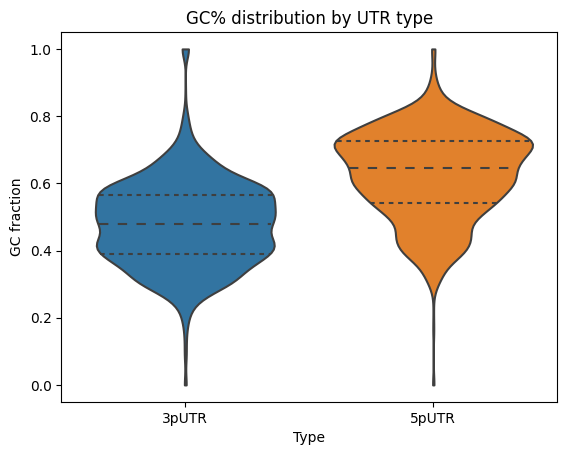

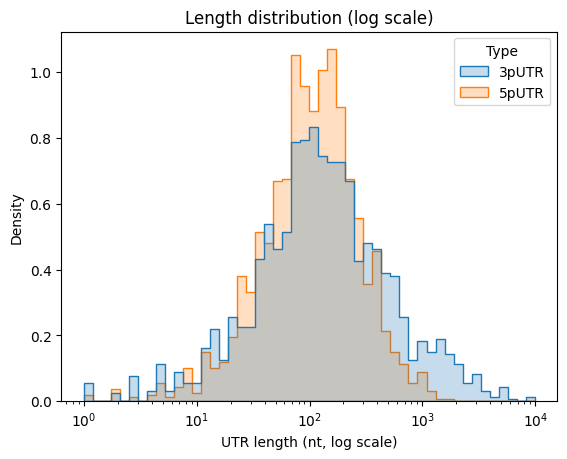

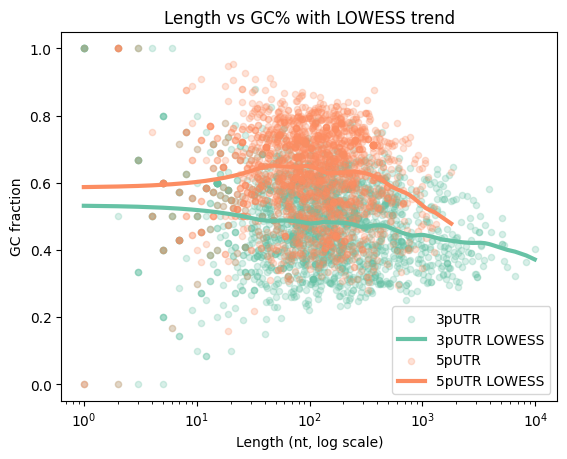

In [5]:
# 1) GC% distribution by UTR type   (violin shows density and quartiles)
sns.violinplot(data=df, x='Type', y='GCpercent', inner='quartile', cut=0)
plt.title('GC% distribution by UTR type')
plt.ylabel('GC fraction')
plt.show()

# 2) Length distribution by UTR type  (log-scale exposes 'heavy right tail')
sns.histplot(data=df, x='Length', hue='Type',
             element='step', bins=50, stat='density',
             common_norm=False, log_scale=True)
plt.title('Length distribution (log scale)')
plt.xlabel('UTR length (nt, log scale)')
plt.show()

# 3) Length × GC% with LOWESS (Locally Weighted Scatter-plot Smoothing) trend 
from statsmodels.nonparametric.smoothers_lowess import lowess

palette = dict(zip(['3pUTR', '5pUTR'], sns.color_palette('Set2', 2)))
fig, ax = plt.subplots()

for utr_type, col in palette.items():
    sub = df[df['Type'] == utr_type]

    ax.scatter(sub['Length'], sub['GCpercent'],
               color=col, alpha=0.25, s=20, label=f'{utr_type}')
    sm = lowess(sub['GCpercent'], sub['Length'], frac=0.3, return_sorted=True)
    ax.plot(sm[:, 0], sm[:, 1],
            color=col, lw=3, label=f'{utr_type} LOWESS')

ax.set_xscale('log')
ax.set_xlabel('Length (nt, log scale)')
ax.set_ylabel('GC fraction')
ax.set_title('Length vs GC% with LOWESS trend')
ax.legend()
plt.show()


#### Why include the LOWESS curve here?

* **What LOWESS is** – *Locally Weighted Scatter-plot Smoothing* fits a small linear regression around every x-value, using nearby points that are weighted by distance. Sliding this window across the axis yields a smooth curve that follows the central trend of the data **without assuming any particular global shape** (like a straight line).

* **Why I`ve used it in this plot** – The relationship between **UTR length** (highly skewed, shown on a log scale) and **GC content** could be flat, curved and etc.  A LOWESS curve allows to see whatever shape the data actually takes:

  * If the curve is flat ↔ length adds little explanatory power.  
  * If it bends or slopes ↔ length contributes non-linearly, suggesting a need for transformations or interaction terms.

By overlaying LOWESS for each UTR type, we get an immediate, assumption-free visual check before committing to a specific regression model.


### Insights from the EDA plots

| Plot title | What we see | Interpretation |
|------------|-------------|------------------------------|
| **GC% distribution by UTR type** | The 5′-UTR violin sits ~15 pp higher than the 3′-UTR one. Medians (dashed lines) ≈ 0.48 vs 0.66; the two distributions barely overlap except in extreme tails. | **GC content is the key discriminator.** Any model that ignores UTR type will confound length or motif effects with this large composition shift. |
| **Length distribution (log scale)** | On a log axis, 5′-UTRs cluster tightly between ≈ 40 nt – 300 nt (mode ≈ 100 nt). 3′-UTRs occupy the same short range *plus* a heavy right-tail that reaches >1 kb and occasionally ~10 kb. | **Length is highly skewed and type-dependent.** Transform length (log); “average” length is meaningless without stratifying it by the type. |
| **Length vs GC% with LOWESS trend** | Within each type the LOWESS curve is almost flat. 3′-UTRs show a slight GC drop at very long lengths; 5′-UTRs show a weak hump around 100-200 nt, then decline. | **Length adds little extra explanation once type is known.** The mild non-linearity suggests a simple linear (or interaction) term is sufficient in formal models. |

### PCA - motif composition

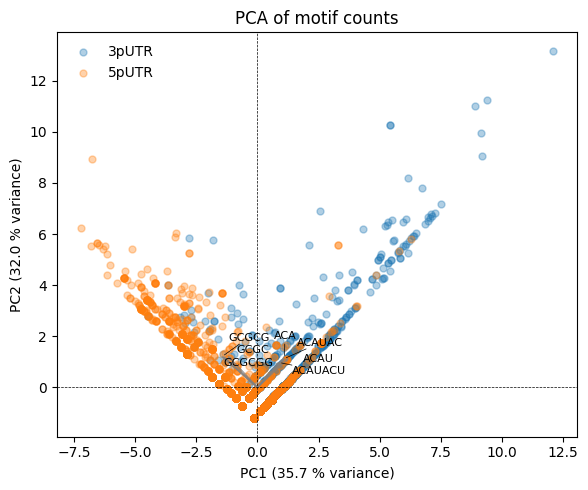

In [9]:
from sklearn.decomposition import PCA
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler

# Motifs types
motif_cols = ['ACAUACU', 'ACAUAC', 'ACAU', 'ACA',
              'GCGCGG', 'GCGCG', 'GCGC']

# Log-transform and scale
X = np.log1p(df[motif_cols])
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(X_scaled)
exp_var = pca.explained_variance_ratio_ * 100

# Compute loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

# Color by type
palette = {'3pUTR': 'tab:blue', '5pUTR': 'tab:orange'}
for utr_type, color in palette.items():
    mask = df['Type'] == utr_type
    ax.scatter(pcs[mask, 0], pcs[mask, 1],
               label=utr_type, color=color, alpha=0.35, s=25)

# Draw arrows and labels
texts = []
for i, motif in enumerate(motif_cols):
    x = loadings[i, 0] * 2
    y = loadings[i, 1] * 2
    ax.arrow(0, 0, x, y, color='gray', alpha=0.7,
             head_width=0.08, length_includes_head=True)
    text = ax.text(x, y, motif, fontsize=8)
    texts.append(text)

# Adjusted text positions to prevent overlap of motifs names
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

ax.set_xlabel(f'PC1 ({exp_var[0]:.1f} % variance)')
ax.set_ylabel(f'PC2 ({exp_var[1]:.1f} % variance)')
ax.set_title('PCA of motif counts')
ax.axhline(0, lw=0.5, ls='--', color='k')
ax.axvline(0, lw=0.5, ls='--', color='k')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


### PCA of motif counts – what the plot reveals

| Aspect | Observation | Interpretation |
|--------|-------------|----------------|
| **Explained variance** | PC1 = **35.7 %** &nbsp;|&nbsp; PC2 = **32.0 %** &nbsp;→ Together **≈ 68 %** of all variation in the seven motif counts. | Two dimensions seemingly capture the dominant data structure. |
| **Cluster separation** | • **3′ UTRs (red)** occupy the **right half** of the plot.<br>• **5′ UTRs (blue)** stay almost exclusively on the **left**.<br>• There is minimal overlap along the PC1 axis. | **PC1 is the major discriminator between UTR classes.** 3′ UTRs are compositionally distinct from 5′ UTRs in motif space. |
| **Loading arrows** | • **AU-rich motifs** (ACA, ACAU, ACAUAC…) point **right** (positive PC1).<br>• **GC-rich motifs** (GCGC, GCGCG, GCGCGG) point **left** (negative PC1). | PC1 is essentially an **AU-motif vs GC-motif** axis: positive values mean “more AU motifs,” negative values “more GC motifs.” |
| **PC2 structure** | Points form a “V” shape; both classes rise along PC2 as they move away from the origin. | **PC2 reflects motif abundance**. Sequences rich in any motifs lie higher on the plot. |
| **Outliers** | A few of 3′ UTRs appear at extreme upper-right (very high PC1 & PC2). | These are **AU-rich outliers** containing dozens–hundreds of ACA-family motifs—consistent with the heavy right tail seen in the previous box-plot. |
| **Bio take-away** | 3′ UTRs are **AU-element enriched** and show wider variation in total motif load; 5′ UTRs are **GC-repeat enriched** and compositionally tighter. | Supports the hypothesis that each UTR class deploys distinct regulatory motif repertoires, tied to their different GC content profiles. |


## Welch’s t-test on GC% between 3′ and 5′ UTR

In [7]:
from scipy import stats

gc3 = df.loc[df['Type'] == '3pUTR', 'GCpercent']
gc5 = df.loc[df['Type'] == '5pUTR', 'GCpercent']

# 1) Welch’s two-sample t-test
t_stat, p_val = stats.ttest_ind(gc3, gc5, equal_var=False)
print(f"Welch t = {t_stat:.2f}, p = {p_val:.2e}")

# 2) 95 % CI for difference in means (3′ – 5′)
def welch_ci(a, b, alpha=0.05):
    n1, n2 = len(a), len(b)
    m1, m2 = np.mean(a), np.mean(b)
    v1, v2 = np.var(a, ddof=1), np.var(b, ddof=1)
    se = np.sqrt(v1/n1 + v2/n2)
    df_ = (v1/n1 + v2/n2)**2 / ((v1**2)/(n1**2*(n1-1)) + (v2**2)/(n2**2*(n2-1)))
    tcrit = stats.t.ppf(1 - alpha/2, df_)
    diff = m1 - m2
    return diff - tcrit*se, diff + tcrit*se, n1, n2, v1, v2

ci_low, ci_high, n1, n2, v1, v2 = welch_ci(gc3, gc5)
print(f"95 % CI for (mean 3′ − mean 5′): [{ci_low:.3f}, {ci_high:.3f}]")

# 3) effect size (Cohen’s d for unequal Ns, unequal SDs)
pooled_sd = np.sqrt(((n1 - 1)*v1 + (n2 - 1)*v2) / (n1 + n2 - 2))
cohen_d = (gc3.mean() - gc5.mean()) / pooled_sd
print(f"Cohen’s d = {cohen_d:.2f}")


Welch t = -36.22, p = 1.38e-248
95 % CI for (mean 3′ − mean 5′): [-0.156, -0.140]
Cohen’s d = -1.15



| Statistic | Value | What it means |
|-----------|-------|---------------|
| **Welch *t*** | −36.22 | The difference in means is > 30 SDs away from zero—**big** relative to within-group variability. |
| **Two-sided *p*-value** | 1.4 × 10⁻²⁴⁸ | Probability of observing such an extreme gap by chance is effectively zero → **highly significant**. |
| **Mean difference (3′ − 5′)** | −0.148 GC units | 3′ UTRs are, on average, **14.8 percentage points lower** in GC content than 5′ UTRs. |
| **95 % CI** | [−0.156, −0.140] | We are 95 % confident the true gap lies between −15.6 pp and −14.0 pp. |
| **Cohen’s *d*** | −1.15 | The effect size is **very large** (>0.8): GC distributions are well separated. |

**Interpretation**

GC content differs dramatically between UTR classes:  
*5′ UTRs are consistently GC-richer by ~15 percentage points.*  
The confidence interval is narrow and far from zero, confirming both statistical and practical significance. 

In sum, GC composition is a primary distinguishing feature of 3′ versus 5′ UTRs and must be accounted for in any downstream modelling.


## Linear regression: GC% ~ Length + UTR type

Ordinary Least Squares (OLS):
                            OLS Regression Results                            
Dep. Variable:              GCpercent   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     698.8
Date:                Fri, 23 May 2025   Prob (F-statistic):          5.51e-261
Time:                        11:47:20   Log-Likelihood:                 2551.5
No. Observations:                4000   AIC:                            -5097.
Df Residuals:                    3997   BIC:                            -5078.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       

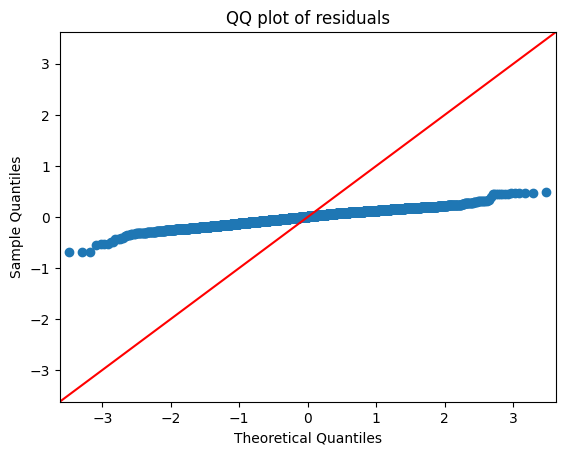

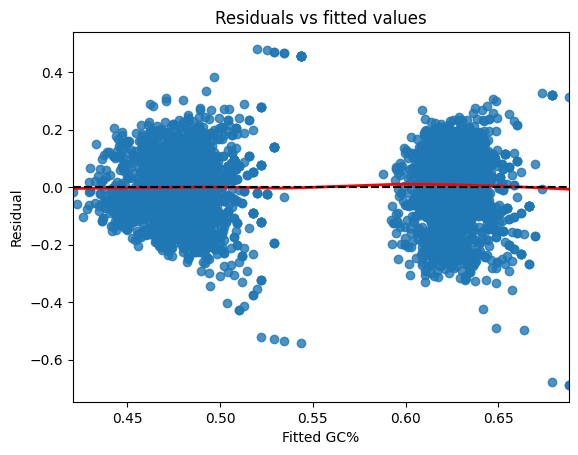

In [12]:
# Linear regression: GC% ~ log(Length) + UTR type
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# log-transform length (skew)
df['logLen'] = np.log(df['Length'])

# main-effects model
print ("Ordinary Least Squares (OLS):")
mem = smf.ols('GCpercent ~ logLen + Type', data=df).fit()
print(mem.summary())

print ("Plots:")
# assumption checks 
# 1) QQ plot of residuals
sm.qqplot(mem.resid, line='45')
plt.title('QQ plot of residuals')
plt.show()

# 2) Residuals vs fitted
sns.residplot(x=mem.fittedvalues, y=mem.resid, lowess=True, 
              line_kws={'lw': 2, 'color': 'red'})
plt.axhline(0, ls='--', color='k')
plt.xlabel('Fitted GC%')
plt.ylabel('Residual')
plt.title('Residuals vs fitted values')
plt.show()


| Term | Coefficient ± SE | *t* | *p* | Interpretation |
|------|-----------------|-----|-----|----------------|
| **Intercept** (baseline = 3′ UTR, Length = 1 nt) | 0.544 ± 0.008 | 64.0 | < 1 e-300 | A hypothetical 1-nt 3′ UTR would average **54 % GC**. |
| **Type = 5′ UTR** | **+0.144 ± 0.004** | 35.5 | < 1 e-300 | Holding length constant, **5′ UTRs are ≈ 14 pp GC-richer** than 3′ UTRs. |
| **log(Length)** | **−0.013 ± 0.002** | −8.1 | 1.2 × 10-15 | In 3′ UTRs, a 10-fold rise in length lowers GC by **≈ 1.3 pp**; the effect seems small but significant. |

**Model fit:** R² = 0.259 (Adj R² = 0.259)  
→ UTR type + length jointly explain **≈ 26 % of GC-content variance**.

---

#### Diagnostics  

| Check | What we see | Verdict |
|-------|-------------|---------|
| **QQ plot** | Mild S-shaped deviation; tails heavier than normal. | Good enough – normality assumption okay for this size of the dataset. |
| **Residuals vs fitted** | Two dense clouds (one per UTR type) with roughly constant vertical spread; LOWESS (red) is close to zero. | Variances look constant – regression assumptions seems to be fulfilled. |

---

#### Key points

* **UTR type is the dominant driver**: its +0.144 coefficient closely matches the Welch gap (~15 pp).  
* **Length has a modest, directionally opposite effect**: longer 3′ UTRs trend AU-richer.  
* **Overall explanatory power is moderate** (one quarter of variance), implying other factors—e.g., coding context, species, or additional motifs—also influence GC%.  
* Assumption checks show **no significant violations**, thus standard OLS inferences are trustworthy.

In short, adding log-length refines the picture but does not alter the main conclusion: **5′ UTRs are substantially GC-richer than 3′ UTRs, independent of sequence length**.


# Discussion

My research question was as follows: *How do sequence length and untranslated region (UTR) type (3′ vs 5′) influence GC content, and what patterns in motif composition underlie any differences?*

### Key findings  

| Evidence | Take-away | Bio-implication |
|----------|-----------|------------------------|
| **Descriptive statistics & violin plot** – median GC: 3′ = 48 %, 5′ = 66 % | GC content is the most conspicuous difference between UTR classes. | Distinct selective pressures on 5′ leaders (e.g. RNA-structure or translation initiation cues) drive GC enrichment. |
| **Welch’s *t*-test** – Δ = −0.148 GC units, 95 % CI [−0.156, −0.140], *d* = 1.15 | The GC gap is not just significant (*p* ≈ 10⁻²⁴⁸) but **practically substencial**. | Any downstream model that ignores UTR type will be confounded; GC% can serve as a strong classifier of UTR identity. |
| **Length distribution (log-scale)** | 3′ UTRs span 2 orders of magnitude, 5′ UTRs remain compact. | Regulatory complexity at transcripts’ 3′ ends (miRNA sites, AU-rich decay elements) tolerates long tails; 5′ ends are constrained by scanning initiation. |
| **Linear regression** – GC % ~ log(Length) + Type (R² ≈ 0.26) | • Switching from 3′ to 5′ UTR raises GC by ≈ 14 pp.<br>• A 10× length increase lowers GC by ≈ 1.3 pp (small but reliable). | UTR class is the dominant predictor; length exerts a mild anti-GC trend (possibly because very long 3′ UTRs are AU-rich). |
| **Assumption checks (QQ, residual plots)** | Residuals are near-normal, constant within classes. | Inferences from OLS are trustworthy; no transformation beyond log-length was required. |
| **PCA of motif counts** – PC1=AU-rich vs GC-rich axis, 68 % variance in PC1+2 | 3′ UTRs cluster on the AU side (ACA family); 5′ UTRs on the GC-repeat side (GCGC family). | Motif repertoire echoes bulk composition, reinforcing the idea that sequence chemistry underlies functional divergence. |

### Synthesis

1. **UTR type is the primary driver** of compositional and motif differences. A ~15 pp GC gap, shown by both the *t*-test and regression coefficient, minimizes all other effects.

2. **Length matters, but modestly.** The negative log-length slope indicates that very long 3′ UTRs tend to be AU-rich, yet the effect changes GC by only about one percentage point per order of magnitude in length.

3. **Motif content aligns with GC chemistry.** PCA shows that AU-rich regulatory elements (e.g. ACA, ACAU) dominate 3′ UTRs, whereas GC-rich repeats (GCGC…) dominate 5′ UTRs, providing a mechanistic link between overall base composition and specific cis-elements.

4. **Model adequacy is confirmed.** Diagnostic plots reveal no serious violations; thus, conclusions about coefficients and their confidence intervals are reliable.

### Conclusion

The analysis demonstrates that **5′ UTRs are systematically GC-richer and motif-wise more GC-repeat-laden than 3′ UTRs, independent of sequence length**. Length adds nuance but does not overturn the central compositional divide. These findings highlight distinct evolutionary and functional constraints operating at opposite ends of mRNAs.
